In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

# Process Categorical Variable
- one-hot encoding
- lable encoding

In [4]:
train_df_target = train_df["loan_status"]
train_df_features = train_df.drop(["loan_status", "id"], axis=1)

test_df_features = test_df.drop(["id"], axis=1)

In [5]:
class LoanFeatureEncoder:
    def __init__(self, dataframe):
        self.df = dataframe
        self.oh_encoder = OneHotEncoder(sparse_output=False)
        self.label_encoder = LabelEncoder()
        self.encoded_features = None

    def encode_features(self, oh_features, grade_ordering, default_ordering):
        # one-hot encode the categorical features
        features_encoded = self.oh_encoder.fit_transform(self.df[oh_features])
        encoded_df = pd.DataFrame(features_encoded, columns=self.oh_encoder.get_feature_names_out(oh_features))

        self.df.drop(oh_features, axis=1, inplace=True)
        self.df = pd.concat([self.df, encoded_df], axis=1)

        # label encode the ordinal features
        self.df["loan_grade"] = pd.Categorical(self.df["loan_grade"], categories=grade_ordering, ordered=True)
        self.df["loan_grade"] = self.label_encoder.fit_transform(self.df["loan_grade"])

        self.df["cb_person_default_on_file"] = pd.Categorical(self.df["cb_person_default_on_file"], categories=default_ordering, ordered=True)
        self.df["cb_person_default_on_file"] = self.label_encoder.fit_transform(self.df["cb_person_default_on_file"])

        self.encoded_features = self.df
        return self.encoded_features



In [6]:
oh_features = ["person_home_ownership", "loan_intent"]
grade_ordering = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
default_ordering = ['N', 'Y']

In [7]:
train_encoder = LoanFeatureEncoder(train_df_features)
train_encoded_df_feature = train_encoder.encode_features(oh_features, grade_ordering, default_ordering)

test_encoder = LoanFeatureEncoder(test_df_features)
test_encoded_df_feature = test_encoder.encode_features(oh_features, grade_ordering, default_ordering)

# Model Training

In [8]:
feature_train, feature_test, target_train, target_test = train_test_split(train_encoded_df_feature, train_df_target, 
                                                                          test_size=0.2, random_state=42)


In [9]:
# RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy=0.505, random_state=42)
feature_train, target_train = oversampler.fit_resample(feature_train, target_train)

# RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
feature_train, target_train = undersampler.fit_resample(feature_train, target_train)

print("oversampler:", Counter(target_train))

print("undersampler:", Counter(target_train))

oversampler: Counter({0: 17760, 1: 17760})
undersampler: Counter({0: 17760, 1: 17760})


# Stack Model

In [10]:
# LightGBM
lgbm_params = {
    'objective': 'binary',
    'n_estimators': 800,
    'learning_rate': 0.1,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    "verbose": -1
}

LGB_model = LGBMClassifier(**lgbm_params)
LGB_model.fit(feature_train, target_train)
lgb_pred_train = cross_val_predict(LGB_model, feature_train, target_train, cv=10, method='predict_proba')[:, 1]

# XGBoost
xgb_param = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'n_estimators': 500,
    'learning_rate': 0.1,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'eval_metric': 'auc',
    'enable_categorical': True
}

XGB_model = XGBClassifier(**xgb_param)
XGB_model.fit(feature_train, target_train)
xgb_pred_train = cross_val_predict(XGB_model, feature_train, target_train, cv=10, method='predict_proba')[:, 1]

# CatBoost
cat_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': 0.1,
    'iterations': 500,
    'depth': 8,
    'l2_leaf_reg': 10,
    'random_strength': 1,
    'random_seed': 42,
    'verbose': False,
    'early_stopping_rounds': 10,
}

CAT_model = CatBoostClassifier(**cat_params)
CAT_model.fit(feature_train, target_train)
cat_pred_train = cross_val_predict(CAT_model, feature_train, target_train, cv=10, method='predict_proba')[:, 1]

In [11]:
# stack the trian data
stacked_train = np.column_stack((lgb_pred_train, cat_pred_train, xgb_pred_train))

# stack the valid data
lgb_pred_test = LGB_model.predict_proba(feature_test)[:, 1]
xgb_pred_test = XGB_model.predict_proba(feature_test)[:, 1]
cat_pred_test = CAT_model.predict_proba(feature_test)[:, 1]

stacked_test = np.column_stack((lgb_pred_test, cat_pred_test, xgb_pred_test))

In [12]:
# Meta model by using ANN
class MetaModel(nn.Module):
    def __init__(self, input_size):
        super(MetaModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        return x

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

stacked_train_tensor = torch.tensor(stacked_train, dtype=torch.float32).to(device)
target_train_tensor = torch.tensor(target_train.values, dtype=torch.float32).view(-1, 1).to(device)
stacked_test_tensor = torch.tensor(stacked_test, dtype=torch.float32).to(device)
target_test_tensor = torch.tensor(target_test.values, dtype=torch.float32).view(-1, 1).to(device)

train_loader = DataLoader(TensorDataset(stacked_train_tensor, target_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(stacked_test_tensor, target_test_tensor), batch_size=32, shuffle=False)

input_size = stacked_train.shape[1]
model = MetaModel(input_size).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

train_losses = []
val_losses = []
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for features, target in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        output = model(features)
        loss = criterion(output, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))
    
    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for features, target in val_loader:
            output = model(features)
            val_loss += criterion(output, target).item()
            
            pred = (output > 0.5).float()
            total += target.size(0)
            correct += (pred == target).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)

    print(f"Epoch: {epoch+1}, Train Loss: {train_losses[-1]:.2f}, Val Loss: {val_loss:.2f}, Val Accuracy: {val_accuracy * 100:.2f}%")

model.eval()
with torch.no_grad():
    output = model(torch.tensor(stacked_train, dtype=torch.float32).to(device))
    predicted = (output >= 0.5).float()
    accuracy = (predicted.view(-1) == torch.tensor(target_train.values, dtype=torch.float32).view(-1).to(device)).sum().item() / len(target_train)

print(f"Final Accuracy: {accuracy * 100:.2f}%")

cuda


c:\Users\jimmy\anaconda3\envs\analysis\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1, Train Loss: 0.14, Val Loss: 0.19, Val Accuracy: 93.92%
Epoch: 2, Train Loss: 0.11, Val Loss: 0.18, Val Accuracy: 94.21%
Epoch: 3, Train Loss: 0.10, Val Loss: 0.19, Val Accuracy: 93.99%
Epoch: 4, Train Loss: 0.10, Val Loss: 0.18, Val Accuracy: 94.31%
Epoch: 5, Train Loss: 0.10, Val Loss: 0.18, Val Accuracy: 94.07%
Final Accuracy: 97.19%


# Evaluate Model

In [14]:
class ModelEvaluator:
    def __init__(self, model, feature_test, target_test):
        self.model = model
        self.feature_test = feature_test
        self.target_test = target_test
        self.predictions = None
        self.target_prob = None

    def evaluate(self):
        self.model.eval()
        with torch.no_grad():
            features_tensor = torch.tensor(self.feature_test, dtype=torch.float32).to(device)
            output = self.model(features_tensor)

            self.predictions = (output > 0.5).float().cpu().numpy()
            self.target_prob = output.cpu().numpy().flatten()

        accuracy = accuracy_score(self.target_test, self.predictions)
        
        print("Accuracy:", accuracy)
        print(classification_report(self.target_test, self.predictions))
        print(confusion_matrix(self.target_test, self.predictions))

    def plot_roc_curve(self):
        fpr, tpr, _ = roc_curve(self.target_test, self.target_prob)
        roc_auc = roc_auc_score(self.target_test, self.target_prob)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

    def plot_confusion_matrix(self):
        cm = confusion_matrix(self.target_test, self.predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

Accuracy: 0.9407184267363874
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     15126
           1       0.78      0.80      0.79      2468

    accuracy                           0.94     17594
   macro avg       0.87      0.88      0.88     17594
weighted avg       0.94      0.94      0.94     17594

[[14574   552]
 [  491  1977]]


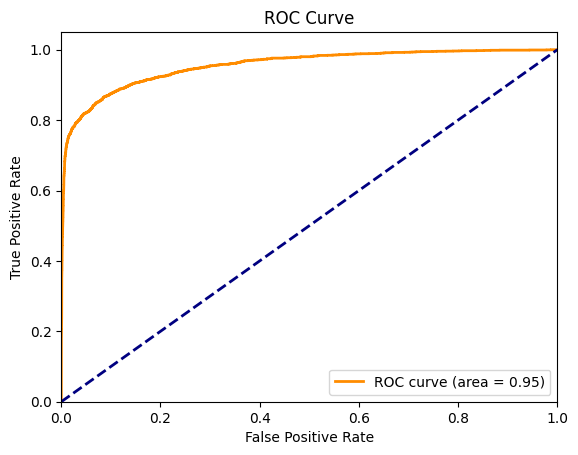

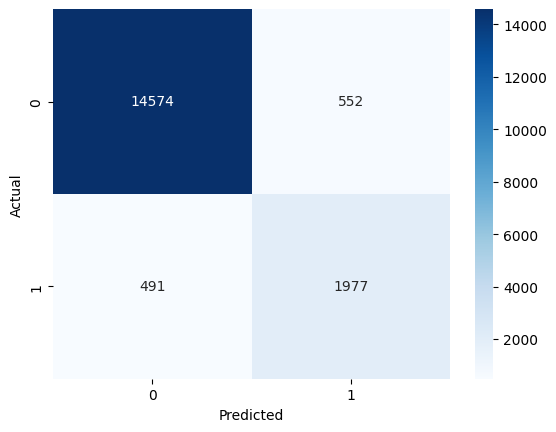

In [15]:
train_evaluator = ModelEvaluator(model, stacked_test, target_test)
train_evaluator.evaluate()
train_evaluator.plot_roc_curve()
train_evaluator.plot_confusion_matrix()

# Prediction

In [16]:
# stack the test data
rf_pred_test = LGB_model.predict_proba(test_encoded_df_feature)[:, 1]
xgb_pred_test = XGB_model.predict_proba(test_encoded_df_feature)[:, 1]
cat_pred_test = CAT_model.predict_proba(test_encoded_df_feature)[:, 1]

stacked_test_data = np.column_stack((rf_pred_test, cat_pred_test, xgb_pred_test))
stacked_test_data_tensor = torch.tensor(stacked_test_data, dtype=torch.float32).to(device)

In [17]:
model.eval()
with torch.no_grad():
    output = model(stacked_test_data_tensor)
    test_pred = (output > 0.5).float().cpu().numpy()

test_df["loan_status"] = test_pred
test_df.to_csv('./output/ann_predictions.csv', columns=["id", "loan_status"], index=False)
